In [91]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.model_selection import train_test_split

In [92]:
Leaf = namedtuple('Leaf', ('value'))
Node = namedtuple('Node', ('feature', 'value', 'left', 'right',))

class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth
        
        self.root = self.build_tree(self.x, self.y)
    
    # Will fail in case of depth ~ 1000 because of limit of recursion calls
    def build_tree(self, x, y, depth=1):
        ### recursive fnction
        if (depth >= self.max_depth) | (self.criteria(y) < 1e-4):
            return Leaf(self.leaf_value(y))
            print(f"depth = {depth}")
        feature, value = self.find_best_split(x, y)
        left, right = self.partition(x, y, feature, value)
        left = self.build_tree(*left, depth = depth + 1)
        right = self.build_tree(*right, depth = depth + 1)
        return Node(feature, value, left, right)
    
    def partition(self, x, y, feature, value):
        ### your code here
        i = x[:, feature] >= value
        return [x[~i], y[~i]], [x[i], y[i]]
    
    def _impurity_partition(self, value, feature, x, y):
        ### call partition
        (_, left), (_, right) = self.partition(x, y, feature, value)
        return self.impurity(left, right)
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        ### use optimize.minimize_scalar to find the best split
        for feature in range(x.shape[1]):
            if x.shape[0] > 2:
                res = optimize.minimize_scalar(
                    self._impurity_partition,
                    args=(feature, x, y),
                    bounds=(x[:, feature].min(), x[:, feature].max()),
                    method='bounded'
                )
                assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = x[:, feature].max()
                impurity = self._impurity_partition(value, feature, x, y)
            if (impurity < best_impurity):
                best_value, best_feature, best_feature = value, feature, impurity
        return best_feature, best_value
        
    def _predict_one(self, x):
        ### your code here
        node = self.root
        while not isinstance(node, Leaf):
            if x[node.feature] > node.value:
                node = node.right
            else:
                node = node.left
        return node.value

    def criteria(self, y):
        ### your code here
        return np.std(y)
        
    def impurity(self, left, right):
        ### weighted l and r impurity
        left_impurity = self.criteria(left)
        right_impurity = self.criteria(right)
        return  (left_impurity*len(left) + right_impurity*len(right))/(len(left) + len(right))

        
class DecisionTreeClassifier(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y, dtype=float)
        self.random_state = np.random.RandomState(random_state)
        self.classes = np.unique(y)
        super().__init__(x, y, *args, **kwargs)
        
    def criteria(self, y):
        ### your code here
        return np.std(y)
        
    def impurity(self, left, right):
        ### weighted l and r impurity
        left_impurity = self.criteria(left)
        right_impurity = self.criteria(right)
        return  (left_impurity*len(left) + right_impurity*len(right))/(len(left) + len(right))
        
    def list_value(self, y):
        class_counts = np.sum(y == self.classes.reshape(-1,1), axis=1)
        m = np.max(class_counts)
        most_common = self.classes[class_counts == m]
        if most_common.size == 1:
            return most_common[0]
        return self.random_state.choice(most_common)

In [93]:
import pandas as pd

In [94]:
data = pd.read_csv("sdss_redshift.csv")
x = data[['u', 'g', 'r', 'i', 'z']]
y = data['redshift']
X_train0, X_test, y_train0, y_test = train_test_split(x, y, test_size=0.5, random_state=np.random.randint(0, np.random.randint(50, 1000)))
y = y_train0
x = X_train0

In [95]:
y0 = y + 0
k = 0 
forest = []
while k < 3:
    k1 = 0
    print(y0)
    garden = []
    while k1 < 50**(1/(k+1)):
        X_train, _, y_train, _ = train_test_split(x, y0, test_size=0.9, random_state=np.random.randint(0, 50000))
        tree = DecisionTreeClassifier(X_train, y_train, random_state=42,max_depth = 10)
        #print(np.mean(np.abs(y0 - tree.predict(x)))/np.mean(np.abs(y0)))
        #if np.mean(np.abs(y0 - tree.predict(x)))/np.mean(np.abs(y0)) < 0.5:
        k1 += 1
        #print(tree.predict(x))
        garden.append(tree)
        print(tree.predict(x))
    y0 = y0 - np.mean([tree.predict(x) for tree in garden],axis=0)
    forest.append(garden)
    k += 1


4843    0.083601
1355    0.086368
1153    0.145242
3569    0.084612
5786    0.096568
          ...   
964     0.134504
2279    0.195404
1228    0.108640
5175    0.153826
5410    0.083380
Name: redshift, Length: 2939, dtype: float64


AttributeError: 'DecisionTreeClassifier' object has no attribute 'leaf_value'

In [ ]:
y_pred = np.sum([np.mean([tree.predict(X_test) for tree in garden], axis=0) for garden in forest], axis=0)


In [ ]:
print(np.array(y_test- y_pred))

[-0.08900187 -0.01999136 -0.02747491 ...  0.00361451  0.00992579
  0.06197498]


In [ ]:
accuracy = np.std(y_test - y_pred)/np.mean(y_test)
print("Accuracy:", accuracy)

Accuracy: 0.46695823580779844


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


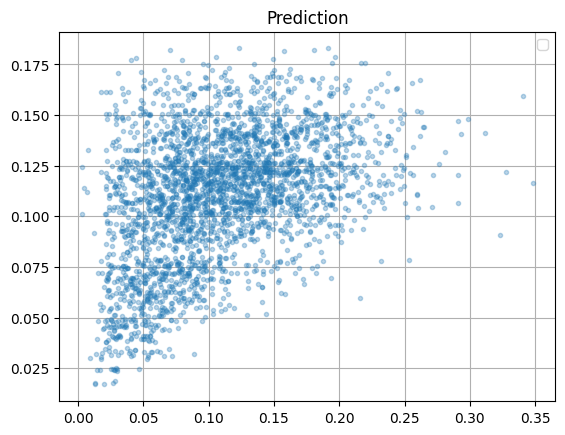

In [ ]:
plt.title("Prediction")
plt.plot(y_test, y_pred , '.', alpha = 0.3)
plt.grid(True)
plt.legend()
plt.savefig("redhift.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


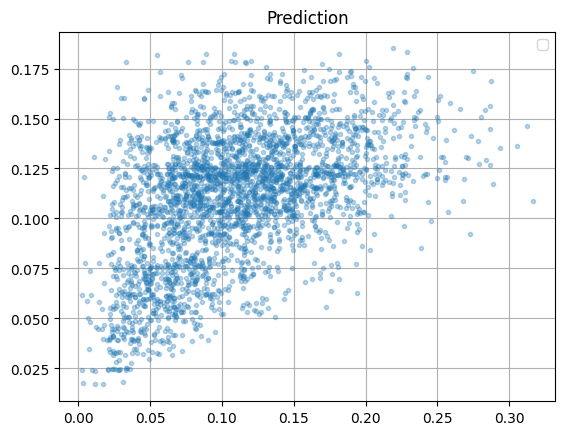

In [ ]:
y_pred = np.sum([np.mean([tree.predict(X_train0) for tree in garden], axis=0) for garden in forest], axis=0)

plt.title("Prediction")
plt.plot(y_train0, y_pred , '.', alpha = 0.3)
plt.grid(True)
plt.legend()
plt.savefig("redhift.png")

In [ ]:
%%script false
Leaf = namedtuple('Leaf', ('value'))
Node = namedtuple('Node', ('feature', 'value', 'left', 'right',))

class BaseDecisionTree:
    def __init__(self, x, y, max_depth=np.inf):
        self.x = np.atleast_2d(x)
        self.y = np.atleast_1d(y)
        self.max_depth = max_depth
        
        self.root = self.build_tree(self.x, self.y)
    
    # Will fail in case of depth ~ 1000 because of limit of recursion calls
    def build_tree(self, x, y, depth=1):
        ### recursive fnction
        if (depth >= self.max_depth) | (self.gini(y) < 1e-4):
            return Leaf(self.leaf_value(y))
            print(f"depth = {depth}")
        feature, value = self.find_best_split(x, y)
        left, right = self.partition(x, y, feature, value)
        left = self.build_tree(*left, depth = depth + 1)
        right = self.build_tree(*right, depth = depth + 1)
        return Node(feature, value, left, right)
    
    def partition(self, x, y, feature, value):
        ### your code here
        i = x[:, feature] >= value
        return [x[~i], y[~i]], [x[i], y[i]]
    
    def find_best_split(self, x, y):
        best_feature, best_value, best_impurity = 0, x[0,0], np.inf
        ### use optimize.minimize_scalar to find the best split
        for feature in range(x.shape[1]):
            if x.shape[0] > 2:
                res = optimize.minimize_scalar(
                    self.impurity,
                    args=(feature, x, y),
                    bounds=(x[:, feature].min(), x[:, feature].max()),
                    method='bounded'
                )
                assert res.success
                value = res.x
                impurity = res.fun
            else:
                value = x[:, feature].max()
                impurity = self.impurity(value, feature, x, y)
            if (impurity < best_impurity):
                best_value, best_feature, best_feature = value, feature, impurity
        return best_feature, best_value
        
    def _predict_one(self, x):
        ### your code here
        node = self.root
        while not isinstance(node, Leaf):
            if x[node.feature] > node.value:
                node = node.right
            else:
                node = node.left
        return node.value

    def dispersion(y):
        return np.sum((y - np.mean(y))**2)
    
    def gini(self, y):
        p1 = np.sum(y)
        p0 = 1. - p1 / y.shape[0]
        p1 /= y.shape[0]
        return 1 - p0**2 - p1**2
    
    def impurity(self, value, feature, x, y):
        i = x[:, feature] >= value
        l = y[~i]
        r = y[i]
        l_criteria = self.gini(l)
        r_criteria = self.gini(r)
        return - l.shape[0] / y.shape[0] * l_criteria - r.shape[0] / y.shape[0] * r_criteria

        
class DecisionTreeClassifier(BaseDecisionTree):
    def __init__(self, x, y, *args, random_state=None, **kwargs):
        y = np.asarray(y, dtype=float)
        self.random_state = np.random.RandomState(random_state)
        self.classes = np.unique(y)
        super().__init__(x, y, *args, **kwargs)
    def list_value(self, y):
        class_counts = np.sum(y == self.classes.reshape(-1,1), axis=1)
        m = np.max(class_counts)
        most_common = self.classes[class_counts == m]
        if most_common.size == 1:
            return most_common[0]
        return self.random_state.choice(most_common)